In [1]:
# https://data.mendeley.com/datasets/wmy84gzngw/1
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/wmy84gzngw-1.zip

--2022-11-06 19:45:48--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/wmy84gzngw-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.97.80, 52.218.106.16, 3.5.70.108, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.97.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3194531 (3.0M) [application/octet-stream]
Saving to: ‘wmy84gzngw-1.zip’

wmy84gzngw-1.zip    100%[===================>]   3.05M  3.19MB/s    in 1.0s    

2022-11-06 19:45:50 (3.19 MB/s) - ‘wmy84gzngw-1.zip’ saved [3194531/3194531]



In [2]:
!pip install -qq timm

## Loading libraries and modules

In [3]:
import os
import random
import shutil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torchvision.io import read_image

import timm

from zipfile import ZipFile

from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from tqdm.auto import tqdm, trange

from pprint import pprint

# Set global config
pd.set_option('display.max_colwidth', None)
SEED = 2022

%config InlineBackend.figure_format = 'retina'

In [4]:
# timm.list_models('vit*')

In [5]:
# model = timm.create_model('vit_base_patch32_224', pretrained=True)
# model.default_cfg

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Preparing data

In [7]:
data_dict = {
    'image_path': [],
    'label': [],
}

for dirpath, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        if not ('mask' in filename):
            
            image_path = os.path.join(dirpath, filename)
            image_label = dirpath.split('/')[-1]
        
            data_dict['image_path'].append(image_path)
            data_dict['label'].append(image_label)

In [8]:
label_encoder = {
    'normal': 0,
    'benign': 1,
    'malignant': 2,
}

df_busi = pd.DataFrame(data_dict)

# Encode labels
df_busi['label'] = df_busi['label'].map(label_encoder)

print(f'BUSI dataset contains {df_busi.shape[0]:_d} rows and {df_busi.shape[1]:_d} columns', '\n')
df_busi

BUSI dataset contains 780 rows and 2 columns 



,image_path,label
0,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png,1
1,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png,1
2,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png,1
3,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png,1
4,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png,1
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (124).png,2
776,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (133).png,2
777,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (6).png,2
778,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (193).png,2


In [9]:
df_busi['label'].value_counts(dropna=False).sort_index()

0    133
1    437
2    210
Name: label, dtype: int64

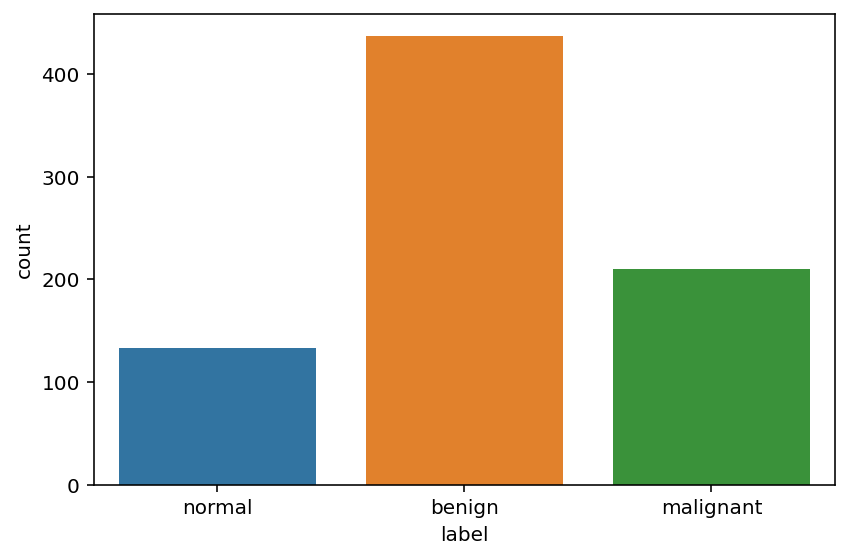

In [10]:
_ = sns.countplot(data=df_busi, x='label')
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'benign', 'malignant'])
plt.tight_layout()

## Adding more data
__Breast Ultrasound Image__

---
Published: 31 December 2017 | Version 1 | DOI: 10.17632/wmy84gzngw.1
Contributor: Paulo Sergio Rodrigues

---
__Description__    
This database contains 250 breast cancer images, 100 benign and 150 malignant. It is a database already widely used in the literature.

In [11]:
zip_file = './wmy84gzngw-1.zip'

with ZipFile(zip_file) as zip_file:
    zip_file.extractall()
    
with ZipFile('./us-dataset.zip') as zip_file:
    zip_file.extractall()

In [12]:
bui_data_dict = {
    'image_path': [],
    'label': [],
}

for dirpath, _, filenames in os.walk('./'):
    
    for filename in filenames:      
        if filename.endswith('.bmp'):
            
            bui_img_path  = os.path.join(dirpath, filename)
            bui_img_label = dirpath.split('/')[-1]
        
            bui_data_dict['image_path'].append(bui_img_path)
            bui_data_dict['label'].append(bui_img_label)

In [13]:
bui_label_encoder = {
    'benign': 1,
    'malignant': 2,
}

df_bui = pd.DataFrame(bui_data_dict)

# Encode labels
df_bui['label'] = df_bui['label'].map(bui_label_encoder)

print(f'BUI dataset contains {df_bui.shape[0]:_d} rows and {df_bui.shape[1]:_d} columns', '\n')
df_bui

BUI dataset contains 250 rows and 2 columns 



,image_path,label
0,./originals/malignant/us214.bmp,2
1,./originals/malignant/us126.bmp,2
2,./originals/malignant/us134.bmp,2
3,./originals/malignant/us228.bmp,2
4,./originals/malignant/us241.bmp,2
...,...,...
245,./originals/benign/us75.bmp,1
246,./originals/benign/us39.bmp,1
247,./originals/benign/us49.bmp,1
248,./originals/benign/us89.bmp,1


In [14]:
df_bui['label'].value_counts(dropna=False).sort_index()

1    100
2    150
Name: label, dtype: int64

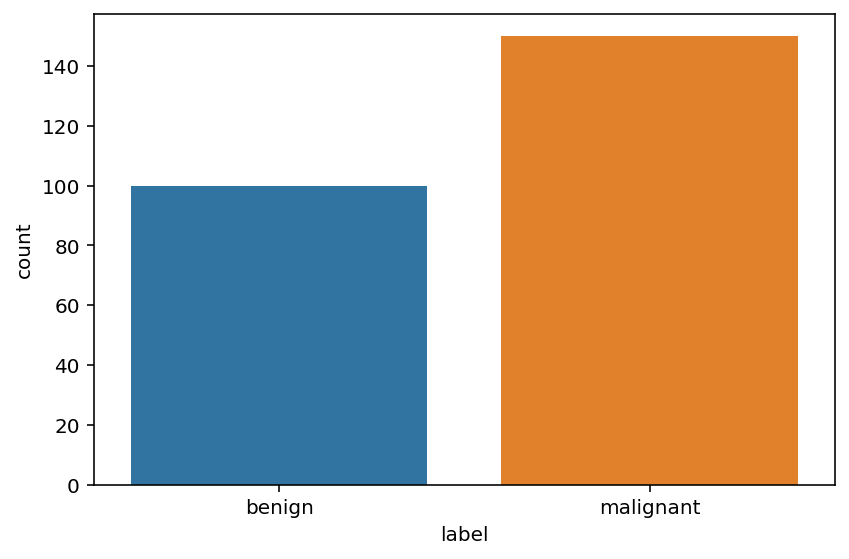

In [15]:
_ = sns.countplot(data=df_bui, x='label')
plt.xticks(ticks=[0, 1], labels=['benign', 'malignant'])
plt.tight_layout()

### Concatenating data

In [16]:
df = pd.concat([df_busi, df_bui])
df

,image_path,label
0,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png,1
1,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png,1
2,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png,1
3,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png,1
4,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png,1
...,...,...
245,./originals/benign/us75.bmp,1
246,./originals/benign/us39.bmp,1
247,./originals/benign/us49.bmp,1
248,./originals/benign/us89.bmp,1


In [17]:
df['label'].value_counts(dropna=False).sort_index()

0    133
1    537
2    360
Name: label, dtype: int64

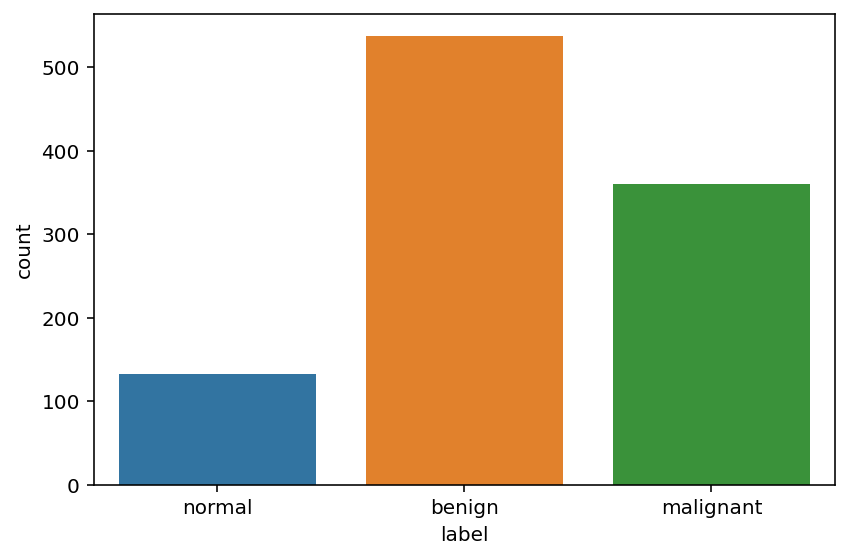

In [18]:
_ = sns.countplot(data=df, x='label')
plt.xticks(ticks=[0, 1, 2], labels=['normal', 'benign', 'malignant'])
plt.tight_layout()

In [19]:
# Sanity check
df['image_path'].nunique(), df['label'].unique()

(1030, array([1, 0, 2]))

## Prepraring data to feed the model

In [20]:
class BUSIDataset(Dataset):
    def __init__(self, annotations, transform=None):
        self.annotations = annotations
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')
        label = self.annotations.iloc[index, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [21]:
# Split data into 80% for training and 20% for testing: 
df_train, df_test = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df['label'])

# Sanity check
df_train.shape, df_test.shape

((824, 2), (206, 2))

In [22]:
transforms_dict = {
    'train': T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize([0.5, 0.5, 0.5],
                                    [0.5, 0.5, 0.5])]),
    
    'valid': T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize([0.5, 0.5, 0.5],
                                    [0.5, 0.5, 0.5])])
}

train_data = BUSIDataset(df_train, transform=transforms_dict['train'])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, 
                          num_workers=2, pin_memory=True)

test_data = BUSIDataset(df_test, transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, 
                         num_workers=0, pin_memory=True)

## Plotting some images

In [23]:
def show_images(images, labels, preds):
    
    img_label_decoder = {
        0: 'normal',
        1: 'benign',
        2: 'malignant',
    }

    plt.figure(figsize=(12, 5))

    for ii, image in enumerate(images[:8]):

        plt.subplot(2, 4, ii + 1, xticks=[], yticks=[])

        image = image.permute(1, 2, 0).numpy()
        mean = np.array([0.5, 0.5, 0.5])    
        std  = np.array([0.5, 0.5, 0.5])
        image = image * std + mean
        image = np.clip(image, a_min=0, a_max=1)
        plt.imshow(image, cmap='bone')

        color = 'green'
        if preds[ii] != labels[ii]:
            color = 'red'

        plt.xlabel(f'{img_label_decoder[int(labels[ii].numpy())]}')
        plt.ylabel(f'{img_label_decoder[int(preds[ii].numpy())]}', color=color)
        
    plt.tight_layout()
    plt.show()

In [24]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

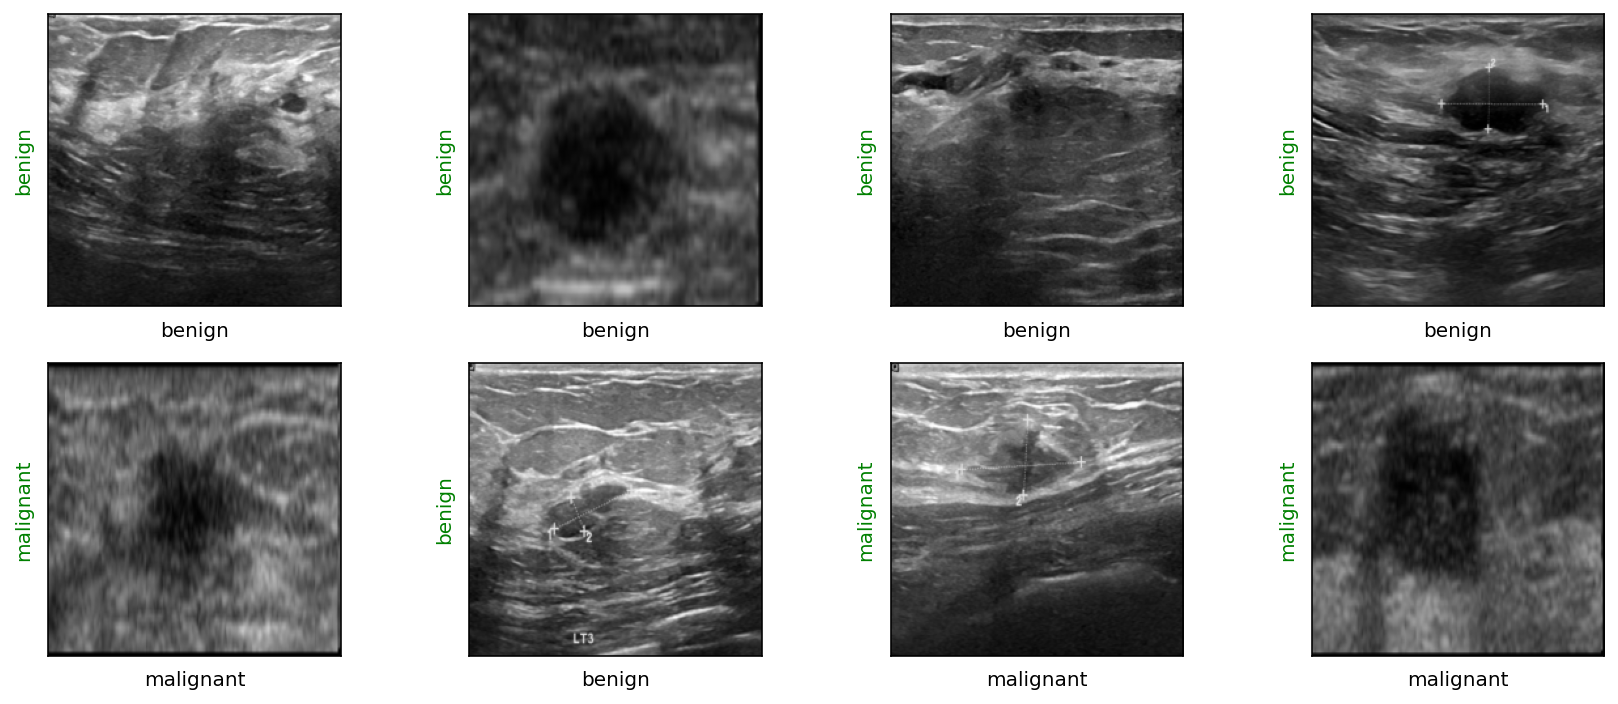

In [25]:
show_images(images, labels, labels)

In [26]:
class BUSIClassifier(nn.Module):
    def __init__(self, pretrained=True, requires_grad=False):
        super().__init__()
        
        self.model = timm.create_model('vit_base_patch32_224', pretrained=pretrained)
        
        print(f'[INFO] pretrained is {True if pretrained else False}')
        
        # Freeze features parameters
        if not requires_grad:
            
            print('[INFO] requires_grad is False')
            for params in self.model.parameters():
                params.requires_grad = False
                
        else:
            print('[INFO] requires_grad is True')
        
        self.model.head = nn.Linear(in_features=768, out_features=3, bias=True)
        
    def forward(self, x):
        
        logits = self.model(x)
        
        return logits

In [27]:
def model_train(loader, model, criterion, optimizer):

    running_loss, accuracy = 0, 0
    y_true, y_pred = [], []

    # Set training mode
    model.train()
    for images, labels in loader:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Store training loss
        running_loss += loss.item()

        # Calculate and store accuracy
        _, preds = torch.max(logits, dim=1)
        
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        
    return (
        (running_loss / len(loader)),                 # loss
        (accuracy_score(y_true, y_pred)),             # accuracy 
        (f1_score(y_true, y_pred, average='macro')),  # macro f1-score  
    )

In [28]:
@torch.no_grad() # turn off gradients
def model_eval(loader, model, criterion):
    
    valid_loss, accuracy = 0, 0
    y_true, y_pred = [], []
    
    # Set evaluation mode
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        # Store validation loss
        valid_loss += loss.item()

        # Calculate and store accuracy
        _, preds = torch.max(logits, dim=1)
        
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        

    scheduler.step(valid_loss / len(valid_loader))
    
    return (
        (valid_loss / len(loader)),                  # loss
        (accuracy_score(y_true, y_pred)),            # accuracy 
        (f1_score(y_true, y_pred, average='macro'))  # f1-score
    )

## Training and validating model

### Training from scratch

In [29]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=False, requires_grad=True)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 50

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------

[INFO] pretrained is False
[INFO] requires_grad is True


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.91585 |  Training Accuracy: 44.53% |  Training f1 score: 0.33958 | Validation loss:    0.97656 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 0.97656. Saving model...
Epoch: 02/50  Training loss:    0.98239 |  Training Accuracy: 51.25% |  Training f1 score: 0.32902 | Validation loss:    0.96267 |  Validation Accuracy: 49.09% |  Validation f1 score: 0.32026
Validation loss decresead: 0.97656 --> 0.96267. Saving model...
Epoch: 03/50  Training loss:    0.99273 |  Training Accuracy: 51.72% |  Training f1 score: 0.31752 | Validation loss:    0.99751 |  Validation Accuracy: 48.48% |  Validation f1 score: 0.32921
Epoch: 04/50  Training loss:    0.99149 |  Training Accuracy: 52.03% |  Training f1 score: 0.33211 | Validation loss:    0.98363 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 05/50  Training loss:    0.97451 |  Training Accuracy: 52.03% |  Training f1 score: 0.33879 | Validat

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.39784 |  Training Accuracy: 39.06% |  Training f1 score: 0.28636 | Validation loss:    0.99669 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 0.99669. Saving model...
Epoch: 02/50  Training loss:    1.01566 |  Training Accuracy: 48.28% |  Training f1 score: 0.31548 | Validation loss:    0.94682 |  Validation Accuracy: 53.33% |  Validation f1 score: 0.35963
Validation loss decresead: 0.99669 --> 0.94682. Saving model...
Epoch: 03/50  Training loss:    1.00588 |  Training Accuracy: 50.00% |  Training f1 score: 0.29713 | Validation loss:    0.98801 |  Validation Accuracy: 37.58% |  Validation f1 score: 0.21656
Epoch: 04/50  Training loss:    0.99765 |  Training Accuracy: 48.75% |  Training f1 score: 0.33761 | Validation loss:    0.95264 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 05/50  Training loss:    0.98214 |  Training Accuracy: 51.41% |  Training f1 score: 0.31891 | Validat

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.36533 |  Training Accuracy: 42.34% |  Training f1 score: 0.30169 | Validation loss:    1.06432 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 1.06432. Saving model...
Epoch: 02/50  Training loss:    1.03203 |  Training Accuracy: 46.25% |  Training f1 score: 0.28725 | Validation loss:    0.95715 |  Validation Accuracy: 53.33% |  Validation f1 score: 0.36291
Validation loss decresead: 1.06432 --> 0.95715. Saving model...
Epoch: 03/50  Training loss:    0.98625 |  Training Accuracy: 52.50% |  Training f1 score: 0.31711 | Validation loss:    0.94017 |  Validation Accuracy: 53.33% |  Validation f1 score: 0.36291
Validation loss decresead: 0.95715 --> 0.94017. Saving model...
Epoch: 04/50  Training loss:    0.99753 |  Training Accuracy: 50.78% |  Training f1 score: 0.33049 | Validation loss:    0.94421 |  Validation Accuracy: 53.33% |  Validation f1 score: 0.36291
Epoch: 05/50  Training loss:    0.99174 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.22745 |  Training Accuracy: 46.25% |  Training f1 score: 0.29833 | Validation loss:    0.97329 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 0.97329. Saving model...
Epoch: 02/50  Training loss:    1.02137 |  Training Accuracy: 51.72% |  Training f1 score: 0.24554 | Validation loss:    0.94462 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: 0.97329 --> 0.94462. Saving model...
Epoch: 03/50  Training loss:    0.99470 |  Training Accuracy: 51.56% |  Training f1 score: 0.23298 | Validation loss:    0.94779 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 04/50  Training loss:    0.98204 |  Training Accuracy: 49.38% |  Training f1 score: 0.27673 | Validation loss:    0.95668 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 05/50  Training loss:    0.97323 |  Training Accuracy: 51.88% |  Training f1 score: 0.29704 | Validat

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.77925 |  Training Accuracy: 39.22% |  Training f1 score: 0.33661 | Validation loss:    1.18786 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: inf --> 1.18786. Saving model...
Epoch: 02/50  Training loss:    1.01940 |  Training Accuracy: 52.03% |  Training f1 score: 0.22816 | Validation loss:    1.00286 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: 1.18786 --> 1.00286. Saving model...
Epoch: 03/50  Training loss:    0.99107 |  Training Accuracy: 50.16% |  Training f1 score: 0.25158 | Validation loss:    1.00104 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: 1.00286 --> 1.00104. Saving model...
Epoch: 04/50  Training loss:    0.99192 |  Training Accuracy: 49.38% |  Training f1 score: 0.30874 | Validation loss:    0.98681 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: 1.00104 --> 0.986

## Evaluating model

In [30]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,1
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,1
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,1
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,2
212,./originals/benign/us9.bmp,1,2
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,2
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,2
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,1
85,./originals/malignant/us192.bmp,2,2


In [32]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        27
      benign       0.54      0.77      0.63       107
   malignant       0.43      0.32      0.37        72

    accuracy                           0.51       206
   macro avg       0.32      0.36      0.33       206
weighted avg       0.43      0.51      0.46       206



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


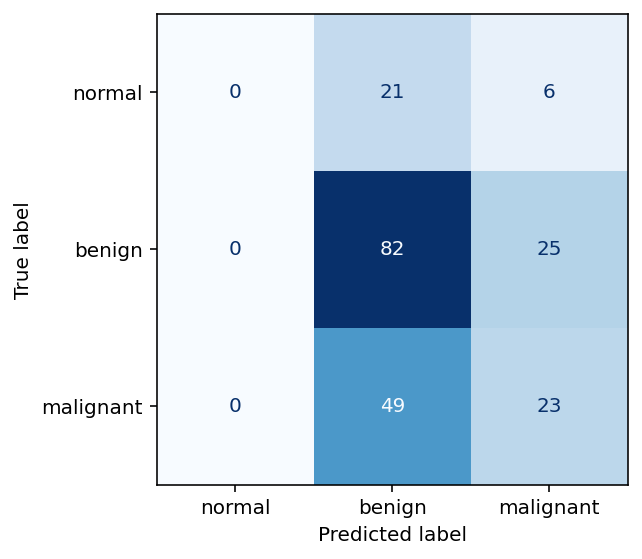

In [33]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()

## Fine Tuning

In [34]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=True, requires_grad=True)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 50

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------

[INFO] pretrained is True
[INFO] requires_grad is True


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.88884 |  Training Accuracy: 43.12% |  Training f1 score: 0.32138 | Validation loss:    0.93425 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 0.93425. Saving model...
Epoch: 02/50  Training loss:    0.99035 |  Training Accuracy: 50.62% |  Training f1 score: 0.29549 | Validation loss:    0.95224 |  Validation Accuracy: 49.70% |  Validation f1 score: 0.32394
Epoch: 03/50  Training loss:    0.99105 |  Training Accuracy: 50.31% |  Training f1 score: 0.32359 | Validation loss:    0.94454 |  Validation Accuracy: 49.09% |  Validation f1 score: 0.32342
Epoch: 04/50  Training loss:    0.95737 |  Training Accuracy: 53.44% |  Training f1 score: 0.35217 | Validation loss:    0.96472 |  Validation Accuracy: 52.73% |  Validation f1 score: 0.36847
Epoch: 05/50  Training loss:    0.97191 |  Training Accuracy: 51.25% |  Training f1 score: 0.32876 | Validation loss:    0.94803 |  Validation Accuracy: 52.12% |  Validatio

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.76680 |  Training Accuracy: 40.00% |  Training f1 score: 0.30714 | Validation loss:    0.99929 |  Validation Accuracy: 35.15% |  Validation f1 score: 0.17339
Validation loss decresead: inf --> 0.99929. Saving model...
Epoch: 02/50  Training loss:    1.03520 |  Training Accuracy: 47.34% |  Training f1 score: 0.31182 | Validation loss:    0.92140 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.24017
Validation loss decresead: 0.99929 --> 0.92140. Saving model...
Epoch: 03/50  Training loss:    1.02068 |  Training Accuracy: 48.75% |  Training f1 score: 0.28038 | Validation loss:    0.91747 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: 0.92140 --> 0.91747. Saving model...
Epoch: 04/50  Training loss:    1.00353 |  Training Accuracy: 52.97% |  Training f1 score: 0.33329 | Validation loss:    1.01687 |  Validation Accuracy: 45.45% |  Validation f1 score: 0.30722
Epoch: 05/50  Training loss:    1.06462 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.12250 |  Training Accuracy: 39.22% |  Training f1 score: 0.30648 | Validation loss:    1.02493 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 1.02493. Saving model...
Epoch: 02/50  Training loss:    1.00329 |  Training Accuracy: 52.97% |  Training f1 score: 0.30663 | Validation loss:    0.97292 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: 1.02493 --> 0.97292. Saving model...
Epoch: 03/50  Training loss:    0.97510 |  Training Accuracy: 53.91% |  Training f1 score: 0.30420 | Validation loss:    1.04301 |  Validation Accuracy: 35.15% |  Validation f1 score: 0.17339
Epoch: 04/50  Training loss:    0.98057 |  Training Accuracy: 51.25% |  Training f1 score: 0.34011 | Validation loss:    0.89656 |  Validation Accuracy: 53.33% |  Validation f1 score: 0.36112
Validation loss decresead: 0.97292 --> 0.89656. Saving model...
Epoch: 05/50  Training loss:    0.94652 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    1.34200 |  Training Accuracy: 47.81% |  Training f1 score: 0.33742 | Validation loss:    0.97203 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: inf --> 0.97203. Saving model...
Epoch: 02/50  Training loss:    1.01127 |  Training Accuracy: 48.75% |  Training f1 score: 0.29401 | Validation loss:    0.94142 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: 0.97203 --> 0.94142. Saving model...
Epoch: 03/50  Training loss:    0.96866 |  Training Accuracy: 53.28% |  Training f1 score: 0.32345 | Validation loss:    0.95235 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Epoch: 04/50  Training loss:    0.99079 |  Training Accuracy: 49.06% |  Training f1 score: 0.32492 | Validation loss:    0.93870 |  Validation Accuracy: 52.12% |  Validation f1 score: 0.22842
Validation loss decresead: 0.94142 --> 0.93870. Saving model...
Epoch: 05/50  Training loss:    0.99722 |  T

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 01/50  Training loss:    2.01346 |  Training Accuracy: 41.41% |  Training f1 score: 0.31820 | Validation loss:    0.99110 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: inf --> 0.99110. Saving model...
Epoch: 02/50  Training loss:    1.01506 |  Training Accuracy: 48.91% |  Training f1 score: 0.30866 | Validation loss:    0.97515 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Validation loss decresead: 0.99110 --> 0.97515. Saving model...
Epoch: 03/50  Training loss:    0.98324 |  Training Accuracy: 49.69% |  Training f1 score: 0.33545 | Validation loss:    0.99720 |  Validation Accuracy: 46.95% |  Validation f1 score: 0.32715
Epoch: 04/50  Training loss:    0.95540 |  Training Accuracy: 51.25% |  Training f1 score: 0.28164 | Validation loss:    0.98186 |  Validation Accuracy: 52.44% |  Validation f1 score: 0.22933
Epoch: 05/50  Training loss:    0.95196 |  Training Accuracy: 54.22% |  Training f1 score: 0.36169 | Validat

## Evaluating model

In [35]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,1
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,1
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,1
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,1
212,./originals/benign/us9.bmp,1,2
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,1
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,1
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,2
85,./originals/malignant/us192.bmp,2,2


In [37]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      0.11      0.20        27
      benign       0.64      0.80      0.71       107
   malignant       0.67      0.64      0.65        72

    accuracy                           0.66       206
   macro avg       0.77      0.52      0.52       206
weighted avg       0.70      0.66      0.62       206



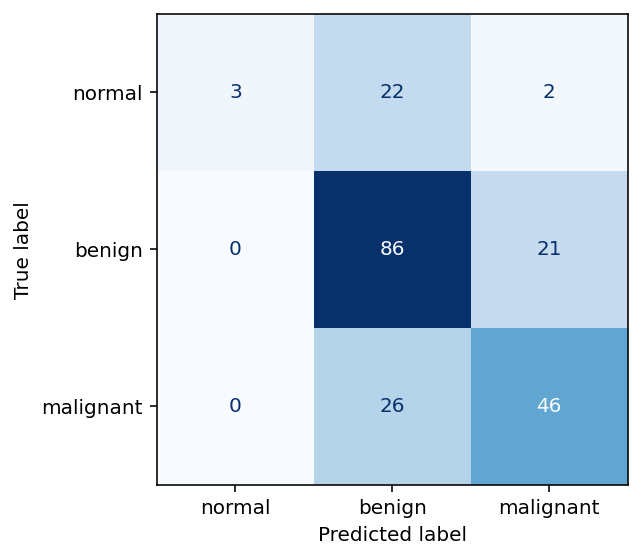

In [38]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()

## Feature Extractor

In [39]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for ii, (train_indices, valid_indices) in enumerate(skfold.split(df_train, df_train['label']), start=1):

    train = df_train.iloc[train_indices]
    valid = df_train.iloc[valid_indices]

    # Split data into traininig and validation sets
    train_data = BUSIDataset(train, transform=transforms_dict['train'])
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    valid_data = BUSIDataset(valid, transform=transforms_dict['valid'])
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print('\n-------')
    print(f'FOLD {ii}')
    print('-------\n')

    # Select avaiable device: GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model
    model = BUSIClassifier(pretrained=True, requires_grad=False)
    model.to(device)

    # Define the loss, optimizar and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)

    epochs = 100

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [], 
        'valid_loss': [], 'valid_acc': [], 'valid_f1': [],
    }

    valid_loss_min = np.Inf

    for epoch in trange(epochs):

        train_loss, train_acc, train_f1 = model_train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_f1 = model_eval(valid_loader, model, criterion)

        print(f'Epoch: {epoch + 1:02d}/{epochs:02d} ',
              f'Training loss: {train_loss:10.5f} | ',
              f'Training Accuracy: {train_acc:5.2%} | ',
              f'Training f1 score: {train_f1:.5f} | '
              f'Validation loss: {valid_loss:10.5f} | ',
              f'Validation Accuracy: {valid_acc:5.2%} | ',
              f'Validation f1 score: {valid_f1:5.5f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decresead: {valid_loss_min:.5f} --> {valid_loss:.5f}. Saving model...')            
            valid_loss_min = valid_loss
            best_model  = torch.save(model.state_dict(), f'model_{ii:02d}.pt')
            best_model_train_loss = train_loss
            best_model_train_acc = train_acc
            best_model_train_f1 = train_f1
            best_model_valid_loss = valid_loss
            best_model_valid_acc = valid_acc
            best_model_valid_f1 = valid_f1

        history['train_loss'].append(best_model_train_loss)
        history['train_acc'].append(best_model_train_acc)
        history['train_f1'].append(best_model_train_f1)
        history['valid_loss'].append(best_model_valid_loss)
        history['valid_acc'].append(best_model_valid_acc)
        history['valid_f1'].append(best_model_valid_f1)

print('\n--------------')            
print(f"Training loss: {np.mean(history['train_loss']):.5f} +/- {np.std(history['train_loss']):.5f} | "
      f"Validation loss: {np.mean(history['valid_loss']):.5f} +/- {np.std(history['valid_loss']):.5f} | "
      f"Training accuracy: {np.mean(history['train_acc']):.2%} +/- {np.std(history['train_acc']):.2%} | "
      f"Validation accuracy: {np.mean(history['valid_acc']):.2%} +/- {np.std(history['valid_acc']):.2%} | "
      f"Training f1 score: {np.mean(history['train_f1']):.5f} +/- {np.std(history['train_f1']):.5f} | "
      f"Validation f1 score: {np.mean(history['valid_f1']):.5f} +/- {np.std(history['valid_f1']):.5f}")
print('--------------')


-------
FOLD 1
-------

[INFO] pretrained is True
[INFO] requires_grad is False


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.84577 |  Training Accuracy: 60.62% |  Training f1 score: 0.47990 | Validation loss:    0.65031 |  Validation Accuracy: 70.30% |  Validation f1 score: 0.63360
Validation loss decresead: inf --> 0.65031. Saving model...
Epoch: 02/100  Training loss:    0.58960 |  Training Accuracy: 73.91% |  Training f1 score: 0.69886 | Validation loss:    0.57519 |  Validation Accuracy: 72.12% |  Validation f1 score: 0.63751
Validation loss decresead: 0.65031 --> 0.57519. Saving model...
Epoch: 03/100  Training loss:    0.48164 |  Training Accuracy: 81.72% |  Training f1 score: 0.79200 | Validation loss:    0.50682 |  Validation Accuracy: 78.79% |  Validation f1 score: 0.68279
Validation loss decresead: 0.57519 --> 0.50682. Saving model...
Epoch: 04/100  Training loss:    0.41282 |  Training Accuracy: 85.00% |  Training f1 score: 0.83360 | Validation loss:    0.51424 |  Validation Accuracy: 74.55% |  Validation f1 score: 0.69415
Epoch: 05/100  Training loss:    0.38206

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.88511 |  Training Accuracy: 58.59% |  Training f1 score: 0.46014 | Validation loss:    0.72118 |  Validation Accuracy: 61.82% |  Validation f1 score: 0.60387
Validation loss decresead: inf --> 0.72118. Saving model...
Epoch: 02/100  Training loss:    0.58922 |  Training Accuracy: 75.47% |  Training f1 score: 0.71512 | Validation loss:    0.56383 |  Validation Accuracy: 75.76% |  Validation f1 score: 0.74238
Validation loss decresead: 0.72118 --> 0.56383. Saving model...
Epoch: 03/100  Training loss:    0.49071 |  Training Accuracy: 80.16% |  Training f1 score: 0.76933 | Validation loss:    0.52047 |  Validation Accuracy: 76.36% |  Validation f1 score: 0.74440
Validation loss decresead: 0.56383 --> 0.52047. Saving model...
Epoch: 04/100  Training loss:    0.43189 |  Training Accuracy: 83.12% |  Training f1 score: 0.80749 | Validation loss:    0.50154 |  Validation Accuracy: 76.97% |  Validation f1 score: 0.73195
Validation loss decresead: 0.52047 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.90045 |  Training Accuracy: 55.16% |  Training f1 score: 0.46551 | Validation loss:    0.68945 |  Validation Accuracy: 71.52% |  Validation f1 score: 0.65027
Validation loss decresead: inf --> 0.68945. Saving model...
Epoch: 02/100  Training loss:    0.59003 |  Training Accuracy: 76.25% |  Training f1 score: 0.70843 | Validation loss:    0.56591 |  Validation Accuracy: 76.36% |  Validation f1 score: 0.69513
Validation loss decresead: 0.68945 --> 0.56591. Saving model...
Epoch: 03/100  Training loss:    0.49316 |  Training Accuracy: 80.00% |  Training f1 score: 0.76756 | Validation loss:    0.53633 |  Validation Accuracy: 75.76% |  Validation f1 score: 0.68484
Validation loss decresead: 0.56591 --> 0.53633. Saving model...
Epoch: 04/100  Training loss:    0.42486 |  Training Accuracy: 84.22% |  Training f1 score: 0.81967 | Validation loss:    0.46561 |  Validation Accuracy: 81.21% |  Validation f1 score: 0.78842
Validation loss decresead: 0.53633 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.88534 |  Training Accuracy: 57.81% |  Training f1 score: 0.44200 | Validation loss:    0.64324 |  Validation Accuracy: 75.15% |  Validation f1 score: 0.66913
Validation loss decresead: inf --> 0.64324. Saving model...
Epoch: 02/100  Training loss:    0.58287 |  Training Accuracy: 75.00% |  Training f1 score: 0.69444 | Validation loss:    0.57590 |  Validation Accuracy: 74.55% |  Validation f1 score: 0.70990
Validation loss decresead: 0.64324 --> 0.57590. Saving model...
Epoch: 03/100  Training loss:    0.50850 |  Training Accuracy: 78.91% |  Training f1 score: 0.76823 | Validation loss:    0.52169 |  Validation Accuracy: 75.76% |  Validation f1 score: 0.71807
Validation loss decresead: 0.57590 --> 0.52169. Saving model...
Epoch: 04/100  Training loss:    0.44396 |  Training Accuracy: 83.44% |  Training f1 score: 0.80474 | Validation loss:    0.47376 |  Validation Accuracy: 81.82% |  Validation f1 score: 0.76374
Validation loss decresead: 0.52169 --> 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01/100  Training loss:    0.88885 |  Training Accuracy: 58.44% |  Training f1 score: 0.49546 | Validation loss:    0.63907 |  Validation Accuracy: 69.51% |  Validation f1 score: 0.65700
Validation loss decresead: inf --> 0.63907. Saving model...
Epoch: 02/100  Training loss:    0.61466 |  Training Accuracy: 74.84% |  Training f1 score: 0.71149 | Validation loss:    0.57193 |  Validation Accuracy: 70.73% |  Validation f1 score: 0.63949
Validation loss decresead: 0.63907 --> 0.57193. Saving model...
Epoch: 03/100  Training loss:    0.48716 |  Training Accuracy: 79.69% |  Training f1 score: 0.76362 | Validation loss:    0.47851 |  Validation Accuracy: 79.88% |  Validation f1 score: 0.76216
Validation loss decresead: 0.57193 --> 0.47851. Saving model...
Epoch: 04/100  Training loss:    0.44263 |  Training Accuracy: 82.97% |  Training f1 score: 0.81777 | Validation loss:    0.44124 |  Validation Accuracy: 79.27% |  Validation f1 score: 0.76947
Validation loss decresead: 0.47851 --> 0

## Evaluating model

In [40]:
y_pred_list = []

for jj in trange(1, 6):

    # Load saved model
    model.load_state_dict(torch.load(f'model_{jj:02d}.pt'))

    y_pred = []

    with torch.no_grad():
        
        model.eval()
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            logits = model(images)

            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.detach().cpu().numpy())
            
    y_pred_list.append(y_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [41]:
df_test['pred'] = np.column_stack(y_pred_list).mean(axis=1).round()
df_test['pred'] = df_test['pred'].astype('int')  # cast predicted values
df_test

,image_path,label,pred
650,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (21).png,2,2
470,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (112).png,0,0
679,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (43).png,2,2
760,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (69).png,2,2
212,./originals/benign/us9.bmp,1,1
...,...,...,...
525,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (132).png,0,0
603,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (143).png,2,1
630,/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (149).png,2,2
85,./originals/malignant/us192.bmp,2,2


In [42]:
target_names = ['normal', 'benign', 'malignant']
print(classification_report(y_true=df_test['label'], y_pred=df_test['pred'], target_names=target_names))

              precision    recall  f1-score   support

      normal       0.86      0.70      0.78        27
      benign       0.81      0.89      0.85       107
   malignant       0.82      0.76      0.79        72

    accuracy                           0.82       206
   macro avg       0.83      0.79      0.81       206
weighted avg       0.82      0.82      0.82       206



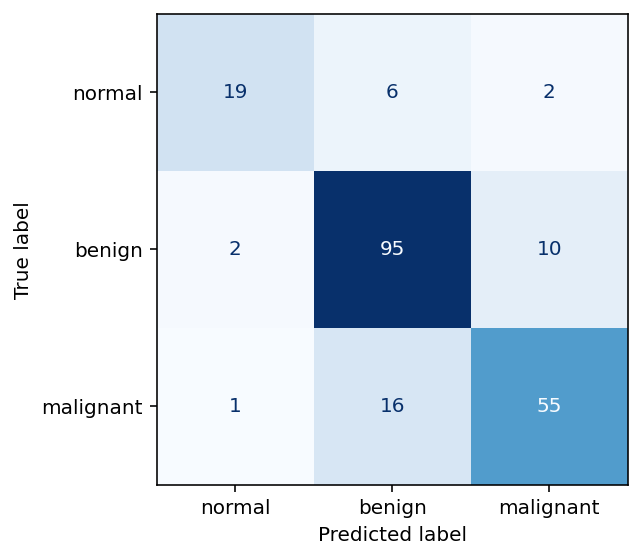

In [43]:
cm = confusion_matrix(y_true=df_test['label'], y_pred=df_test['pred'])
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='Blues', colorbar=False)
plt.tight_layout()